# Extra Credit HW4
## Vector Quantization
Vector quantization is a unique technique.  In the examples we've looked at, feature vectors are of some fixed length (which isn't always the case).  For example, with our image classification tasks, we relied on all images being the same size.  Images are relatively easy to resample so they are all the same size, but that's not the case with all data.

The general idea of vector quantization is that most signals exhibit some form of repetition, regardless of the length, scale, or speed.  Local patterns that are exhibited can say a lot about the signal.  In many cases it's not actually important where those local patterns occur, just which patterns are exhibited that are important (not all -- in speech for instance where they occur is crucially important).

Vector quantization is very often coupled with clustering as a way to group similar small subpieces of a signal and see what a longer signal is composed of to identify the overall signal, which is often then used for classification.

The general process for vector quantization is:
1. Break training signals into small fixed size pieces
2. Cluster the pieces using a clustering method like $k$-means.
3. For new signals (that you wish to classify):
   * Cut the new signal into pieces
   * Record the cluster center of each piece
   * Compute the distribution of the clusters in that signal (this could be visualized with something like a histogram if you wanted to visualize)
   * Classify the resulting distribution with something like nearest neighbors classification (note -- the main difference here is that we aren't classifying the full signal, we are classifying the distribution of clusters in that signal.  For example, if I break up a signal into 30 pieces

The goal of this problem is to apply vector quantization to understand accelerometer data.

## Step 1: Read in the data

In this problem, we are using a [modified version of one of the accelerometer dataset's on UCI's Machine Learning Dataset website](https://drive.google.com/drive/folders/1Mxc0uGHzmldgpiOXLSbBbacCUoL7z4HR?usp=sharing).  If you are curious, you can look at the [full version](https://archive.ics.uci.edu/ml/datasets/Dataset+for+ADL+Recognition+with+Wrist-worn+Accelerometer).  To make it easier to work with, I modified it by pruning down the data significantly to include only 4 different activities and a smaller subset of accelerometer data.

For each activity, there are multiple accelerometers measurements of that data (each as a separate file that contains a @D array where each row is a measurement of x, y, and z)..

The following code cell reads in the data for you and splits it into training and testing sets.  Each set is composed of 2 lists, one containing the labels and one containing the 2D arrays representing each piece of accelerometer data.

In [57]:
'''
Note, to use this you need to:
1. upload the activity-data folder to your google drive
2. update this to wherever activity_data is on your google drive
   (e.g. on mine it's in CIS378/hw4/activity-data)
'''
import os
import matplotlib.pyplot as plt
import numpy as np
import random
import sklearn
from sklearn.cluster import KMeans
from collections import Counter
from google.colab import drive

drive.mount('/content/gdrive')
activity_dir = '/content/gdrive/MyDrive/CIS378/hw4/activity-data'
fnames = os.listdir(activity_dir)
accel_data = []
labels = []
for fname in fnames:
  if fname != 'labels.txt':
    accel_data.append(np.loadtxt(os.path.join(activity_dir, fname), delimiter=' '))
  else:
    f = open(os.path.join(activity_dir, fname), 'r')
    lines = f.readlines()
    for line in lines:
      labels.append(line.strip().split(',')[1])


random.seed(12345)
accel_data_train = []
accel_data_test = []
labels_train = []
labels_test = []
split = random.choices(['train', 'test'], [.75, .25], k=len(labels))
for i in range(len(split)):
  if split[i] == 'train':
    labels_train.append(labels[i])
    accel_data_train.append(accel_data[i])
  else:
    labels_test.append(labels[i])
    accel_data_test.append(accel_data[i])


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Step 2:  Breaking Signals Into Pieces
Each signal (one entry of the accel_data lists is a 2D array).  The following code breaks each signal up into smaller pieces (of size 32 x 3), throwing out the last bit if it isn't an even multiple of 32.

These are all combined creating a 3D array of size $4408 \times 32 \times 3$ (e.g. 4408 pieces each of shape $32 \times 3$).

In [ ]:
pieces = []
piece_len = 32
npieces_per_signal = []

for i in range(len(accel_data_train)):
  npieces_per_signal.append(accel_data_train[i].shape[0]//piece_len)
  for j in range(0,accel_data_train[i].shape[0]//piece_len):
    pieces.append(accel_data_train[i][j*32:(j+1)*32])
pieces = np.array(pieces)
print(pieces.shape)

(4408, 32, 3)


To make this into a format amenable to use clustering on we need to reshape the individual pieces from $32 \times 3$ to a flattened $96$.  This is very similar to how we handled the EMNIST images.

In [ ]:
pieces = pieces.reshape(pieces.shape[0], -1)

## Step 3:  Perform k-means clustering on the pieces

Note, the below uses a fixed number of clusters (that is likely not the correct choice).  Once you understand how this code works, use one of the methods for choosing the number of clusters (e.g. Silhouette score analysis, etc.) to experiment with different values of $k$.

Once you've determined how many clusters you should use, repeat what I do below with the chosen number of clusters

In [85]:
model = KMeans(n_clusters=15)
model.fit(pieces)
cluster_labels = model.labels_

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


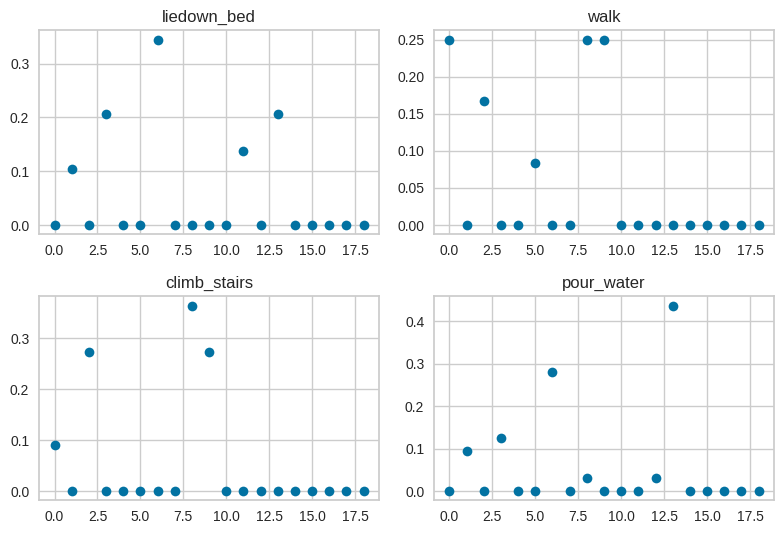

In [86]:
distributions = []
running_counts = np.cumsum([0] + npieces_per_signal)
for i in range(1,len(accel_data_train)+1):
  cluster_labels_piece = cluster_labels[running_counts[i-1]:running_counts[i]]
  values, counts = np.unique(cluster_labels_piece, return_counts=True)
  distributions_piece = np.zeros(k)
  for idx in range(len(values)):
    distributions_piece[values[idx]] = counts[idx]
  distributions_piece /= np.sum(distributions_piece)
  distributions.append(distributions_piece)


plt.subplot(221)
plt.plot(distributions[1], 'bo')
plt.title(labels_train[1])

plt.subplot(222)
plt.plot(distributions[30], 'bo')
plt.title(labels_train[30])

plt.subplot(223)
plt.plot(distributions[150], 'bo')
plt.title(labels_train[150])

plt.subplot(224)
plt.plot(distributions[250], 'bo')
plt.title(labels_train[250])
plt.tight_layout()
plt.show()

In [ ]:
# TODO - experiment with different numbers of clusters

## Step 4: Breaking new signals into pieces and identifying distributions

1. To classify the new (e.g. test set) signals, we must first break each of them into pieces (each piece needs to be the same size as the pieces above).  You will want to keep the ones for each signal separately.

2. For all signals, go through all pieces in that signal and identify which cluster those signals belong to.

3. Compute a distribution of the clusters the pieces in that signal belong to.  Save this distribution for each new (e.g. test set) signal.


In [ ]:
# TODO

## Step 5:  Classify the new signals based on their distributions
Use a classification technique such as k-nearest neighbors to classify the new signals (by looking for the closest distributions in the training set to its distribution).  Note, the $k$ used here likely won't be the same value of $k$ used in $k$-means.

Explain how you chose $k$ (make sure not to touch the test set to determine what $k$ to choose).

In [ ]:
# TODO

## Step 6: Compute and evaluate accuracy on the test set
Using the true labels for the test set, how accurate is this vector quantization model?   

In [ ]:
# TODO